In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exercice 7

### Ce dataset est un dataset fait par HELP International qui est une ONG humanitaire internationale. Ce qui va nous interesser c'est le .csv "Country-data". Il comprend 9 features (si on ne compte pas le nom des pays) qui décrivent différents aspects du développement de chaque pays, tels que le taux de mortalité infantile, le PIB par habitant, le taux d'importation, etc. Ce jeu de données est sur Kaggle : https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data

### Notre objectif sera d'utiliser des techniques d'apprentissage non supervisé pour regrouper les pays en fonction de leurs caractéristiques socio-économiques et sanitaires. Plus précisément, nous allons effectuer une analyse de clustering pour identifier des groupes de pays partageant des profils similaires. Cette analyse pourrait aider à comprendre les différents niveaux de développement entre les pays et potentiellement guider des politiques de développement international.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(42)

## 1. Analyse des données

Commençons par charger et examiner les données.

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  

Informations sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float6

<Figure size 1500x1000 with 0 Axes>

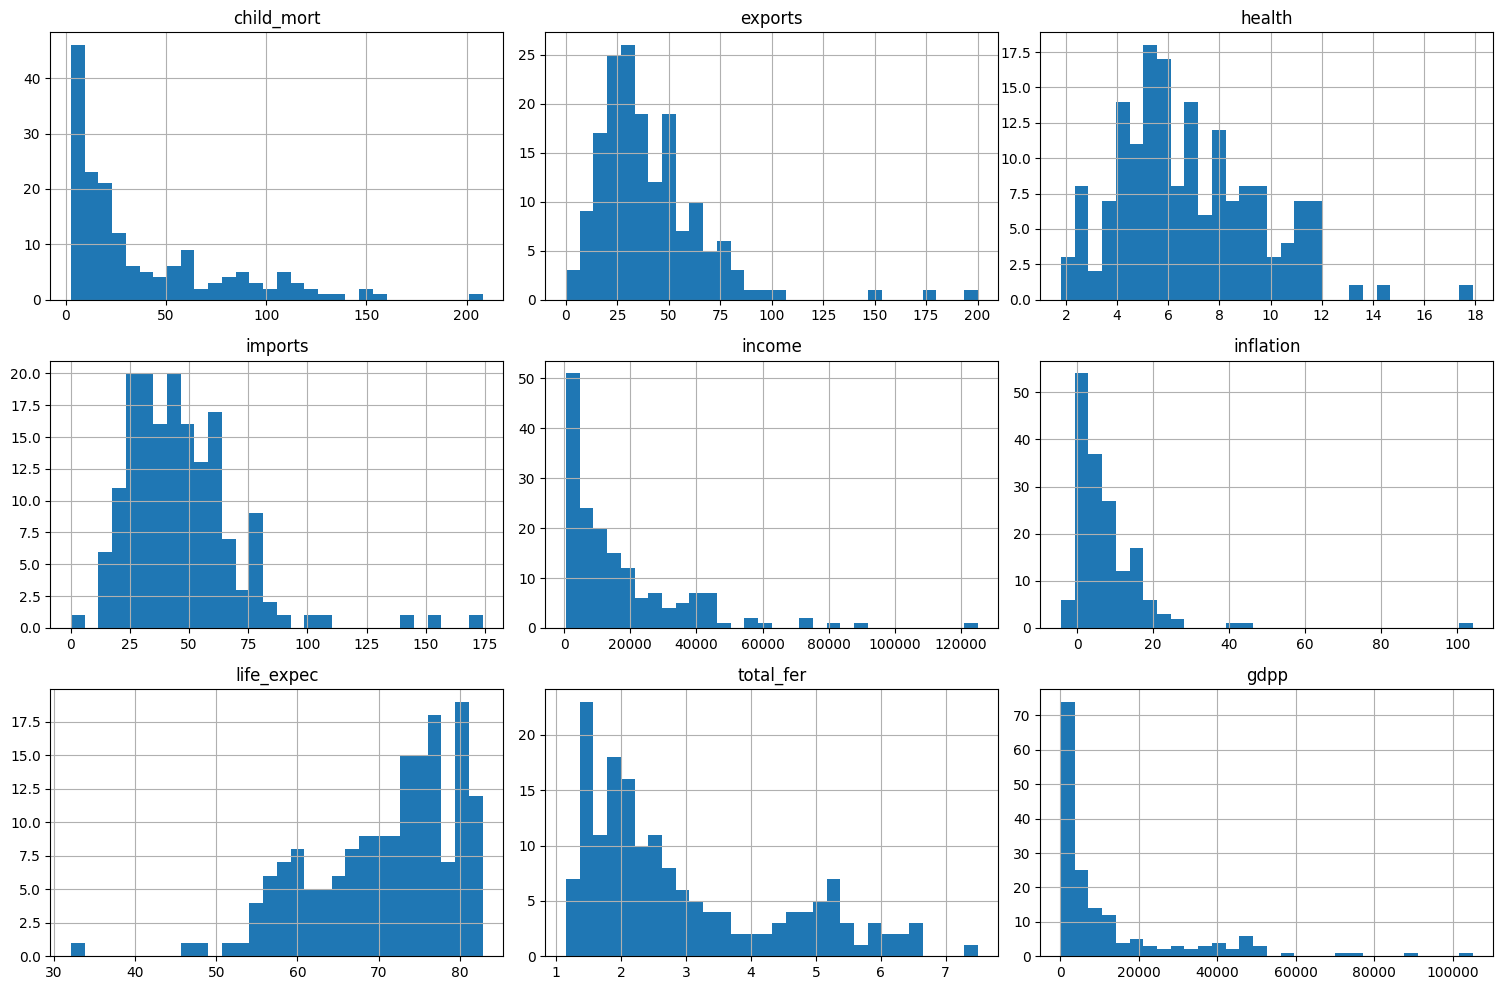

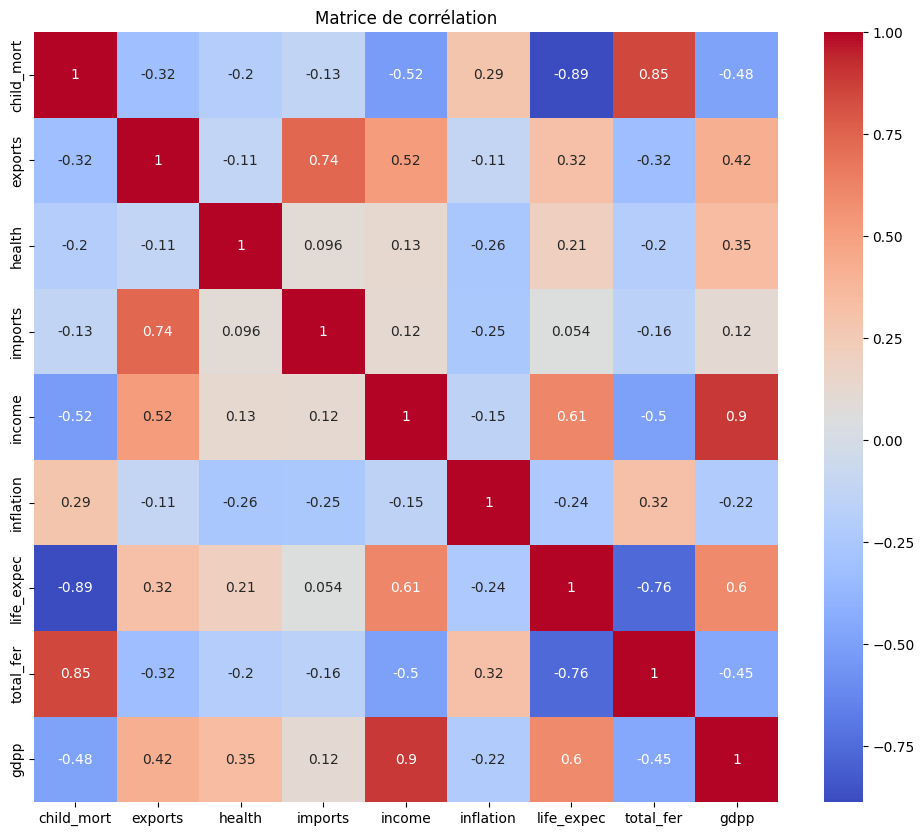

In [17]:
data = pd.read_csv('/kaggle/input/unsupervised-learning-on-country-data/Country-data.csv')

print(data.head())
print("Informations sur le dataset:\n")
print(data.info())

print("Statistiques descriptives:\n")
print(data.describe())

numeric_columns = data.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 10))
data[numeric_columns].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Matrice de corrélation')
plt.show()

### Résultat de l'analyse :

1 - Le jeu de données contient 167 pays avec 10 colonnes, dont une pour le nom du pays et 9 pour les features.

2 - Il n'y a pas de valeurs manquantes, ce qui est un bon point pour notre analyse.

3 - Les variables ont des échelles très différentes, ce qui nécessitera une normalisation avant le clustering.

4 - Certaines variables semblent avoir une distribution asymétrique, notamment le PIB.

5 - Il existe des corrélations significatives entre certaines variables, par exemple entre le taux de mortalité infantile et l'espérance de vie.



## 2. Prétraitement des données

Étant donné les observations précédentes, nous allons :

1 - Séparer les noms des pays du reste des données.

2 - Normaliser les données pour que toutes les variables aient la même échelle.

In [18]:
country_names = data['country']
features = data.drop('country', axis=1)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

print("Forme des données normalisées:", scaled_features.shape)

Forme des données normalisées: (167, 9)


## 3. PCA

Nous allons utiliser une PCA pour réduire la dimension des données et visualiser les pays dans un espace à 2 dimensions.

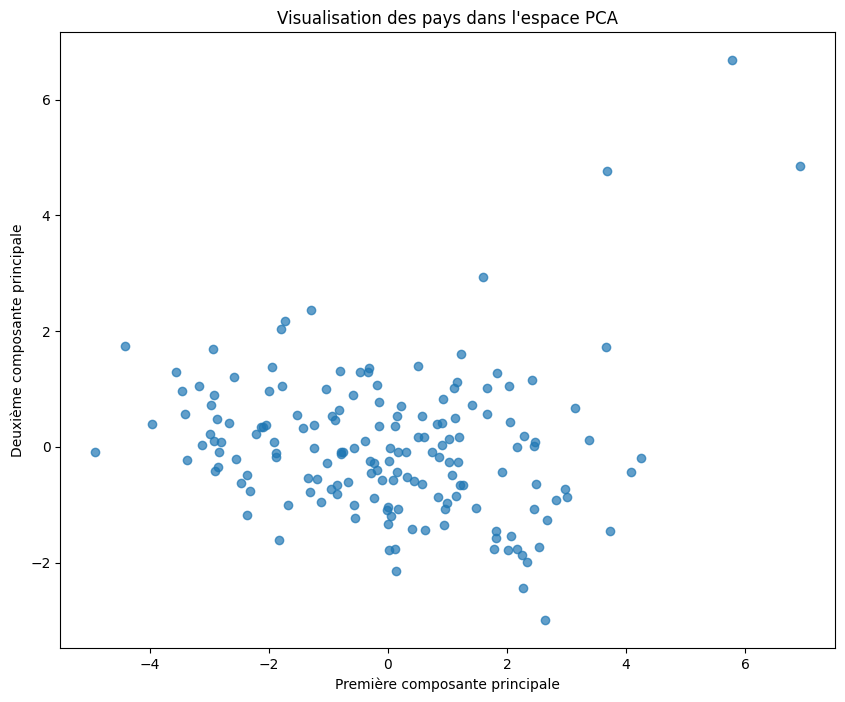

Variance expliquée par les deux premières composantes principales:
[0.4595174  0.17181626]


In [11]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(10, 8))
plt.scatter(pca_features[:, 0], pca_features[:, 1], alpha=0.7)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Visualisation des pays avec PCA')
plt.show()

print("Variance expliquée par les deux premières composantes principales:")
print(pca.explained_variance_ratio_)

Observations de la PCA :

1 - Les deux premières composantes principales expliquent une part significative de la variance totale des données.


## 4. Clustering avec K-means

On va utiliser l'algorithme K-means pour regrouper les pays. Pour choisir le nombre optimal de clusters, on va utiliser la méthode du coude et le score de silhouette.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

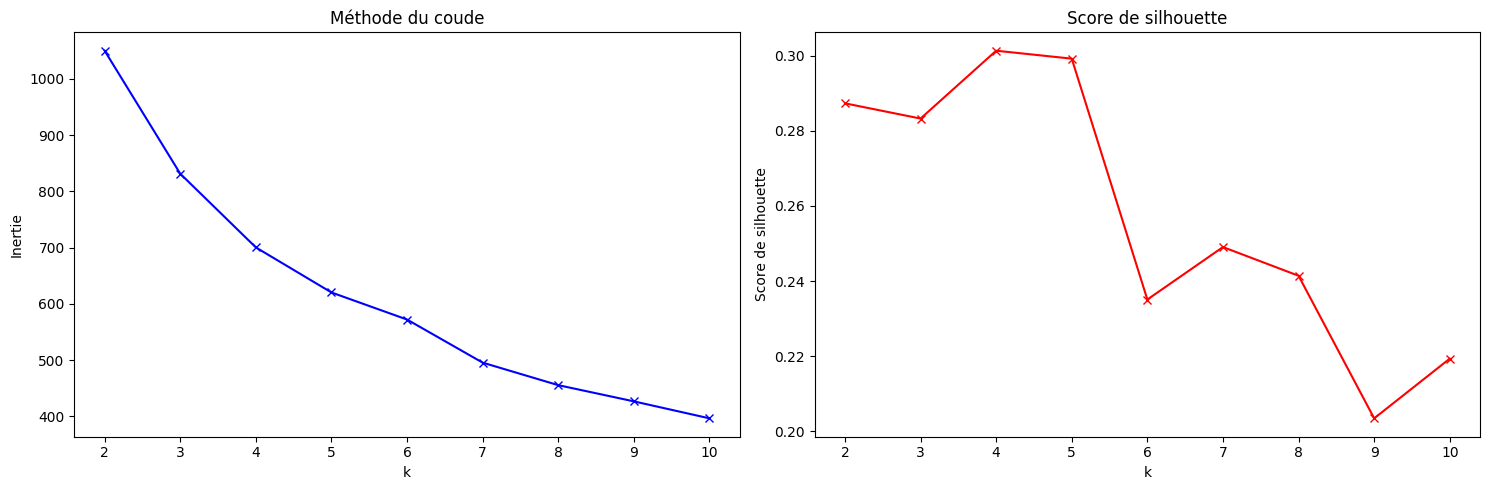

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


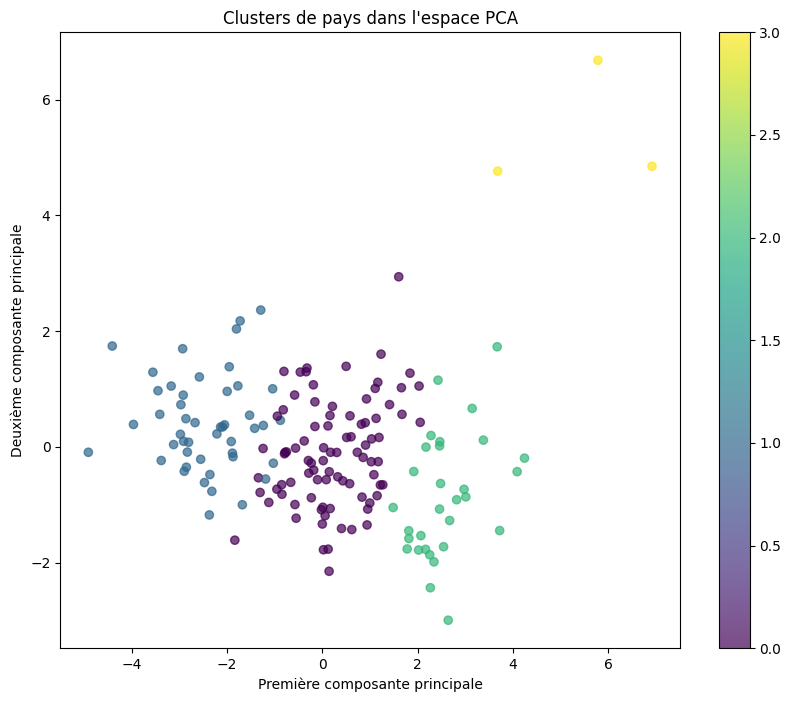

In [19]:
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(k_range, inertias, 'bx-')
ax1.set_xlabel('k')
ax1.set_ylabel('Inertie')
ax1.set_title('Méthode du coude')

ax2.plot(k_range, silhouette_scores, 'rx-')
ax2.set_xlabel('k')
ax2.set_ylabel('Score silhouette')
ax2.set_title('Score silhouette')

plt.tight_layout()
plt.show()

optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

data_with_clusters = data.copy()
data_with_clusters['Cluster'] = cluster_labels

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Clusters de pays avec PCA')
plt.colorbar(scatter)
plt.show()

## 5. Évaluation et interprétation des résultats

Maintenant qu'on a effectué le clustering, on analyse les caractéristiques de chaque cluster.

Caractéristiques moyennes de chaque cluster:

         child_mort     exports    health     imports        income  \
Cluster                                                               
0         21.389655   41.290678  6.235862   48.038689  12968.620690   
1         92.961702   29.151277  6.388511   42.323404   3942.404255   
2          4.953333   45.826667  9.168667   39.736667  45250.000000   
3          4.133333  176.000000  6.793333  156.666667  64033.333333   

         inflation  life_expec  total_fer          gdpp  
Cluster                                                  
0         7.413460   72.935632   2.286552   6919.103448  
1        12.019681   59.187234   5.008085   1922.382979  
2         2.742200   80.376667   1.795333  43333.333333  
3         2.468000   81.433333   1.380000  57566.666667  
Pays représentatifs de chaque cluster:

Cluster 0: Suriname
Cluster 1: Guinea
Cluster 2: Finland
Cluster 3: Singapore


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

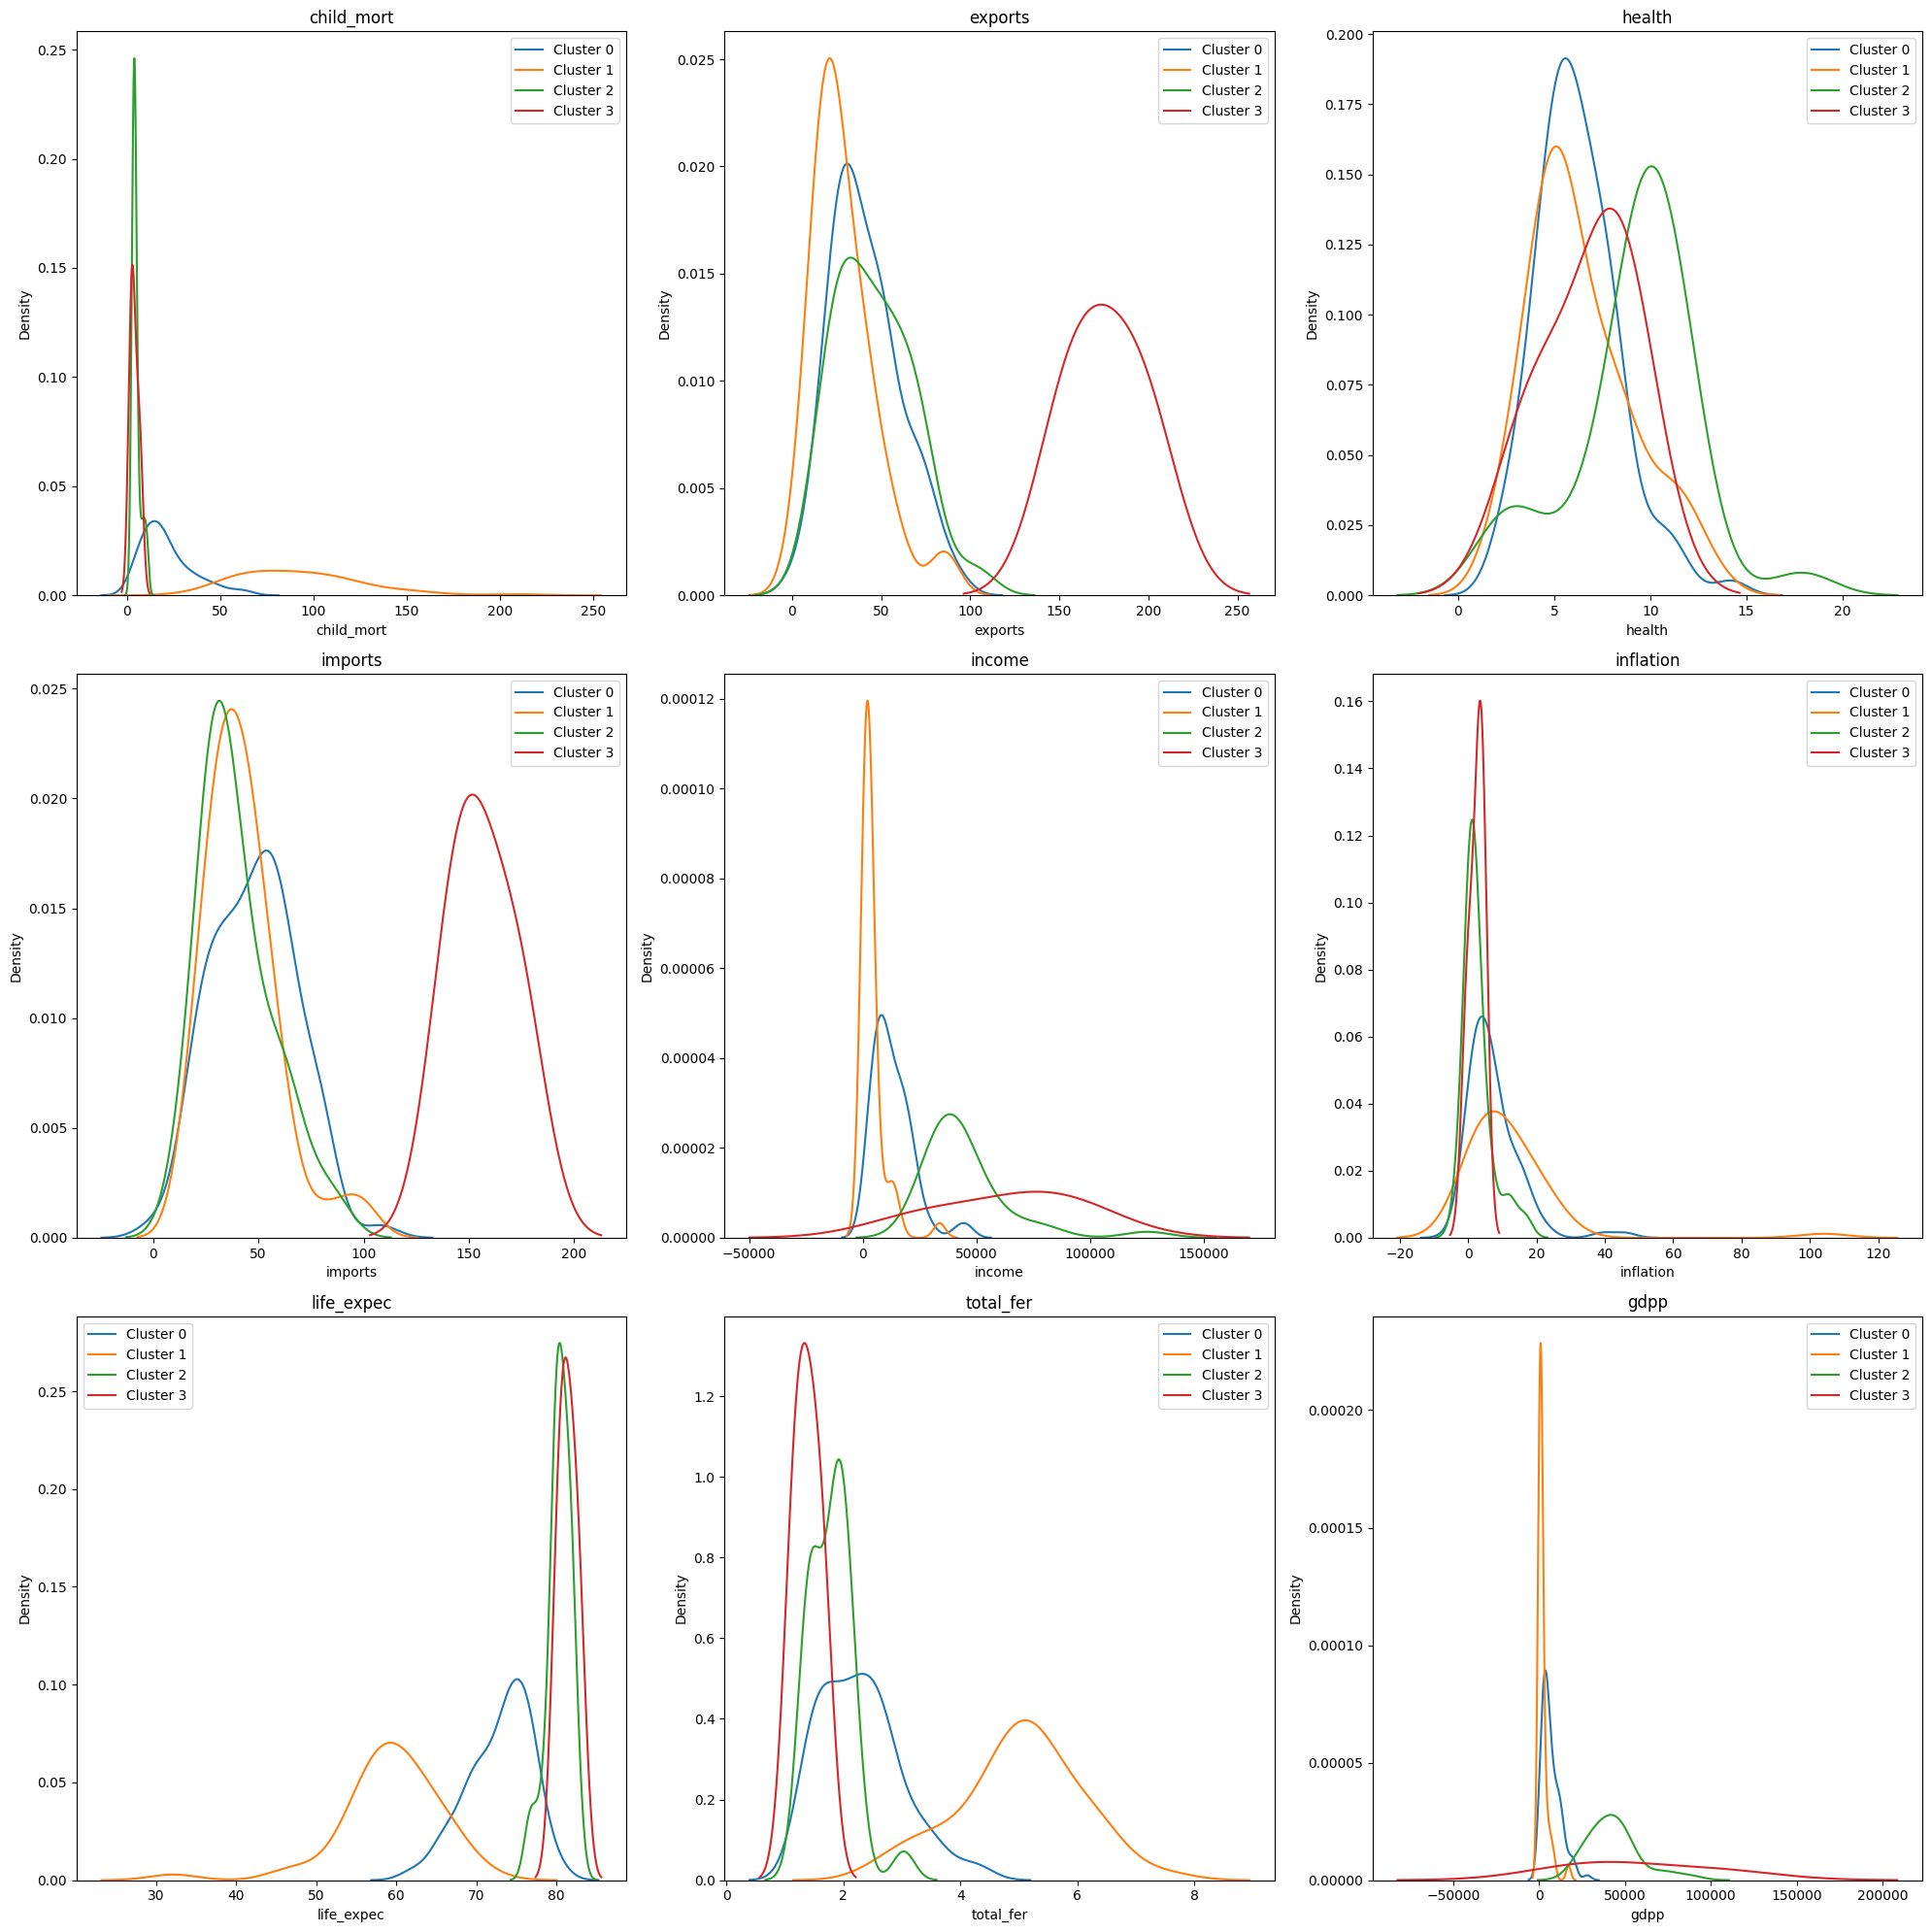

In [20]:
numeric_columns = data_with_clusters.select_dtypes(include=[np.number]).columns
cluster_means = data_with_clusters[numeric_columns].groupby('Cluster').mean()

print("Caractéristiques moyennes de chaque cluster:\n")
print(cluster_means)

representative_countries = []
for i in range(optimal_k):
    cluster_data = scaled_features[cluster_labels == i]
    centroid = kmeans.cluster_centers_[i]
    distances = np.linalg.norm(cluster_data - centroid, axis=1)
    closest_index = distances.argmin()
    representative_countries.append(country_names.iloc[np.where(cluster_labels == i)[0][closest_index]])

print("Pays représentatifs de chaque cluster:\n")
for i, country in enumerate(representative_countries):
    print(f"Cluster {i}: {country}")

data_with_clusters = data_with_clusters.replace([np.inf, -np.inf], np.nan)

fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()

for i, column in enumerate(numeric_columns):
    if column != 'Cluster':
        for cluster in range(optimal_k):
            cluster_data = data_with_clusters[data_with_clusters['Cluster'] == cluster][column].dropna()
            if not cluster_data.empty:
                sns.kdeplot(data=cluster_data, ax=axes[i], label=f'Cluster {cluster}')
        axes[i].set_title(column)
        axes[i].legend()

plt.tight_layout()
plt.show()

## Conclusion et interprétation

Basé sur l'analyse, on peut tirer les conclusions suivantes :

1. Nous avons identifier 4 groupes distincts de pays partageant des caractéristiques socio-économiques et sanitaires similaires.

2. Les clusters semblent représenter différents niveaux de développement :
    - Cluster 0 : Pays à développement intermédiaire (ex: Suriname) - caractérisé par une mortalité infantile modérée, une espérance de vie moyenne, et un PIB par habitant intermédiaire.
    - Cluster 1 : Pays en développement (ex: Guinée) - caractérisé par une forte mortalité infantile, une faible espérance de vie, un taux de fertilité élevé et un faible PIB par habitant.
    - Cluster 2 : Pays développés (ex: Finlande) - caractérisé par une très faible mortalité infantile, une espérance de vie élevée, un faible taux de fertilité et un PIB par habitant élevé.
    - Cluster 3 : Économies avancées et ouvertes (ex: Singapour) - caractérisé par des indicateurs de santé excellents, un PIB par habitant très élevé, et des niveaux d'imports et d'exports exceptionnellement élevés.

3. Les variables qui semblent le plus discriminer les clusters sont la mortalité infantile, l'espérance de vie, le PIB par habitant, et le taux de fertilité.

4. Cette analyse est utile pour :
   - Identifier des groupes de pays ayant des défis de développement similaires.
   - Cibler des interventions de développement en fonction des caractéristiques spécifiques de chaque groupe.
   - Faciliter les comparaisons entre pays ayant des profils similaires.

Cette analyse fournit un aperçu intéressant des similitudes et des différences entre les pays en termes de développement, ce qui pourrait être un point de départ utile pour des analyses plus approfondies et des décisions politiques informées.